In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modülleri
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc

# Uyarıları kapat
import warnings
warnings.filterwarnings('ignore')

# Grafik Ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print(">>> Kütüphaneler başarıyla yüklendi.")

>>> Kütüphaneler başarıyla yüklendi.


In [2]:
# Veri setini yükle (Noktalı virgül ile ayrılmış CSV)
try:
    df = pd.read_csv('data.csv', sep=';')
    print(f">>> Veri Seti Yüklendi. Boyut: {df.shape}")
except FileNotFoundError:
    print("HATA: 'data.csv' dosyası bulunamadı. Lütfen dosyanın aynı dizinde olduğundan emin olun.")

>>> Veri Seti Yüklendi. Boyut: (4424, 37)


In [3]:
# Yeni özellikler türeterek modelin zekasını artırıyoruz:
print(">>> Feature Engineering işlemleri yapılıyor...")

# A) Ders Geçme Oranları (Approved / Enrolled)
df['App_Rate_1st'] = df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (enrolled)'].replace(0, 1)
df['App_Rate_2nd'] = df['Curricular units 2nd sem (approved)'] / df['Curricular units 2nd sem (enrolled)'].replace(0, 1)

# B) Genel Not Ortalaması
df['Grade_Avg'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# C) Performans Değişimi (2. Dönem notu - 1. Dönem notu)
df['Grade_Change'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']

# D) Ekonomik Baskı Endeksi
df['Eco_Stress'] = df['Unemployment rate'] * df['Inflation rate']

print(f">>> Yeni Özellikler Eklendi. Güncel Sütun Sayısı: {df.shape[1]}")

>>> Feature Engineering işlemleri yapılıyor...
>>> Yeni Özellikler Eklendi. Güncel Sütun Sayısı: 42


In [4]:
print(">>> Veri Ön İşleme Adımları...")

# 1. Hedef Değişken Dönüşümü (Binary: Dropout vs Not Dropout)
df['Target_Binary'] = df['Target'].apply(lambda x: 'Dropout' if x == 'Dropout' else 'Not Dropout')

# 2. X ve y ayrımı
X = df.drop(['Target', 'Target_Binary'], axis=1)
y = df['Target_Binary']

# 3. Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f">>> Sınıf Kodlaması: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 4. Veri Bölme (%80 Train - %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 5. Ölçeklendirme (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(">>> Veri başarıyla bölündü ve ölçeklendi.")

>>> Veri Ön İşleme Adımları...
>>> Sınıf Kodlaması: {'Dropout': np.int64(0), 'Not Dropout': np.int64(1)}
>>> Veri başarıyla bölündü ve ölçeklendi.


In [5]:
print(">>> Baseline Model (Dummy) Eğitiliyor...")

# Strategy 'stratified': Eğitim setindeki sınıf dağılımına göre rastgele atama yapar.
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train_scaled, y_train)
dummy_pred = dummy_clf.predict(X_test_scaled)

print(f"Baseline Accuracy: %{accuracy_score(y_test, dummy_pred)*100:.2f}")

>>> Baseline Model (Dummy) Eğitiliyor...
Baseline Accuracy: %58.87


In [6]:
print(">>> Random Forest için Hyperparameter Tuning Başlatılıyor (GridSearchCV)...")
print(">>> Bu işlem biraz zaman alabilir, lütfen bekleyiniz...")

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Aranacak parametre uzayı
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# 3-Katmanlı Çapraz Doğrulama
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
print(f"\n>>> En İyi Parametreler: {grid_search.best_params_}")

>>> Random Forest için Hyperparameter Tuning Başlatılıyor (GridSearchCV)...
>>> Bu işlem biraz zaman alabilir, lütfen bekleyiniz...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

>>> En İyi Parametreler: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [7]:
print(">>> Voting Classifier (RF + HGB + GB) Oluşturuluyor...")

# Diğer modeller
hgb_clf = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=200, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Voting: Tuned Random Forest + HGB + GB
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('hgb', hgb_clf), ('gb', gb_clf)],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
print(">>> Voting Classifier Eğitimi Tamamlandı.")

>>> Voting Classifier (RF + HGB + GB) Oluşturuluyor...
>>> Voting Classifier Eğitimi Tamamlandı.


>>> Test Seti Üzerinde Değerlendirme Yapılıyor...

 TEST ACCURACY: %87.12
 TEST F1-SCORE: %86.89
              precision    recall  f1-score   support

     Dropout       0.84      0.74      0.79       284
 Not Dropout       0.88      0.93      0.91       601

    accuracy                           0.87       885
   macro avg       0.86      0.84      0.85       885
weighted avg       0.87      0.87      0.87       885



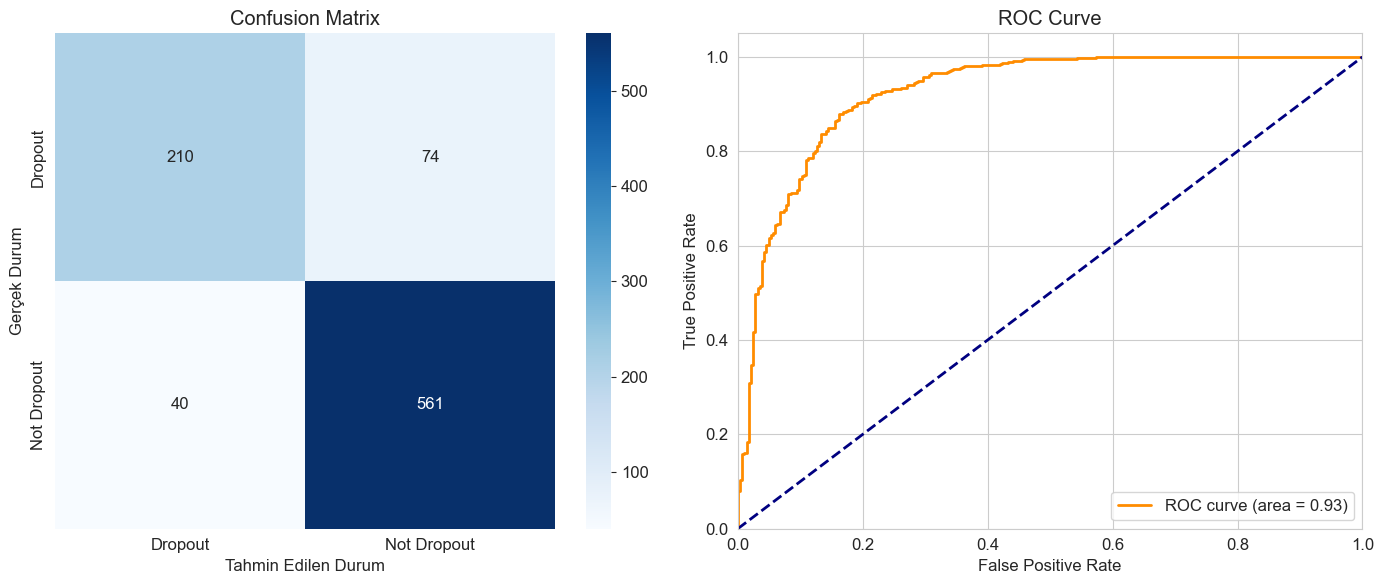

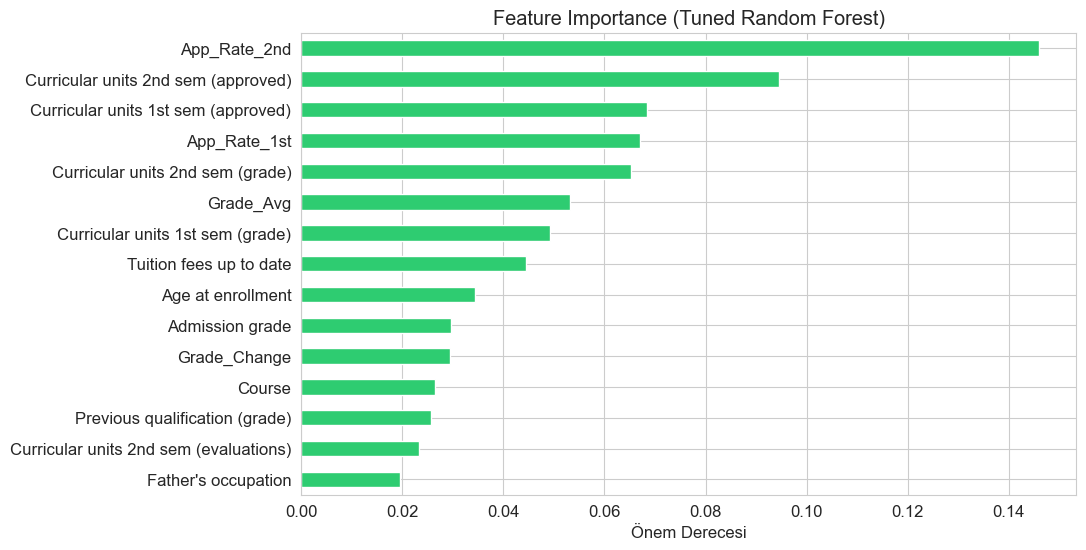

In [8]:
print(">>> Test Seti Üzerinde Değerlendirme Yapılıyor...")

test_pred = voting_clf.predict(X_test_scaled)
test_probs = voting_clf.predict_proba(X_test_scaled)[:, 1] # ROC için pozitif sınıf olasılıkları

# Metrikler
print(f"\n========================================")
print(f" TEST ACCURACY: %{accuracy_score(y_test, test_pred)*100:.2f}")
print(f" TEST F1-SCORE: %{f1_score(y_test, test_pred, average='weighted')*100:.2f}")
print(f"========================================")
print(classification_report(y_test, test_pred, target_names=le.classes_))

# --- GÖRSEL 1: Confusion Matrix ---
plt.figure(figsize=(14, 6)) # Genişlik artırıldı yan yana sığsın diye

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')

# --- GÖRSEL 2: ROC Curve (ZORUNLU) ---
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# --- GÖRSEL 3: Feature Importance (Best RF üzerinden) ---
plt.figure(figsize=(10, 6))
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='#2ecc71')
plt.title('Feature Importance (Tuned Random Forest)')
plt.xlabel('Önem Derecesi')
plt.show()